<a href="https://colab.research.google.com/github/souchem23/data-science-coursework/blob/main/Unit8/SoumikC_U8_Proj_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Unit 8 Project: Sleep Prediction**

##**PART I: Imports/Preparation**

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import graphviz as gr
import pandas as pd
import pymc as pm
import seaborn as sns

In [2]:
!pip install pymc-bart

In [3]:
import pymc_bart as pmb

##**PART II: Introduction**

For my unit 8 project, I will use BART to construct a model that **predicts how students sleep** based on lifestyle factors. These factors include physical activity, caffeine intake, average heart rate, alcohol consumption, and anxiety level. Most studies have not included biological factors and physiological factors such as breathing rate and anxiety level, so this investigation hopes to fill those gaps.

**Casual Diagram**

In [4]:
import graphviz

dot = graphviz.Digraph(format='png')

dot.node("activity", "Physical Activity")
dot.node("caff", "Caffeine Intake")
dot.node("hr", "Average Heart Rate")
dot.node("alc", "Alcohol Consumption")
dot.node("anx", "Anxiety Level")
dot.node("sleep", "Sleep Hours")

dot.edge("activity", "hr")
dot.edge("activity", "anx")
dot.edge("activity", "sleep")

dot.edge("caff", "sleep")
dot.edge("caff", "anx")

dot.edge("hr", "sleep")

dot.edge("alc", "hr")
dot.edge("alc", "anx")
dot.edge("alc", "sleep")

dot.edge("anx", "sleep")
dot.edge("anx", "hr")

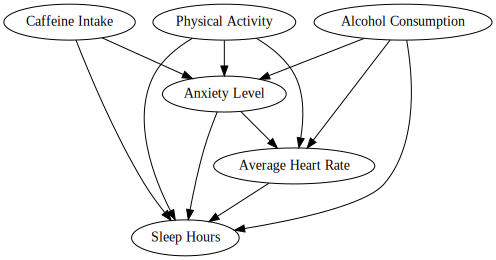

In [5]:
dot

**Further Description of Features**

Specifically, I will look at **Caffeine Intake**, **Average Heart Rate**, **Physical Activity**, and **Anxiety Level**. I don't want to include Alcohol Consumption as a feature because it is likely only prevalent in a few cases, and may incorrectly influence the sleep prediction being performed with this model. Below is how each of the features is defined:


*   *Caffeine Intake*: Amount of caffeine taken daily
*   *Average Heart Rate*: Measured throughout various periods throughout the day and averaged together
*   *Physical Activity*: Rated on a scale based on one's exercise on average
*   *Anxiety Level*: Also rated on a medical scale based on an individual's results on a questionnaire/survey.





##**PART III: Data and Feature Extraction**

Data is going to be taken from Kaggle and modified based on the casual diagram created above.

In [6]:
# Reading in the data
solarDataURL = 'https://raw.githubusercontent.com/souchem23/data-science-coursework/refs/heads/main/enhanced_anxiety_dataset.csv'

# Creating dataframe representation
solarData = pd.read_csv(solarDataURL)
solarData = solarData.head(1000)
solarData.rename(columns={'Sleep Hours': 'sleep'}, inplace=True)
solarData.rename(columns={'Physical Activity (hrs/week)': 'activity'}, inplace=True)
solarData.rename(columns={'Caffeine Intake (mg/day)': 'caffeine'}, inplace=True)
solarData.rename(columns={'Heart Rate (bpm)': 'hr'}, inplace=True)
solarData.rename(columns={'Breathing Rate (breaths/min)': 'br'}, inplace=True)
solarData.rename(columns={'Alcohol Consumption (drinks/week)': 'alc'}, inplace=True)
solarData.rename(columns={'Anxiety Level (1-10)': 'anx'}, inplace=True)

# Display processed data
solarData

,Age,Gender,Occupation,sleep,activity,caffeine,alc,Smoking,Family History of Anxiety,Stress Level (1-10),hr,br,Sweating Level (1-5),Dizziness,Medication,Therapy Sessions (per month),Recent Major Life Event,Diet Quality (1-10),anx
0,29,Female,Artist,6.0,2.7,181,10,Yes,No,10,114,14,4,No,Yes,3,Yes,7,5.0
1,46,Other,Nurse,6.2,5.7,200,8,Yes,Yes,1,62,23,2,Yes,No,2,No,8,3.0
2,64,Male,Other,5.0,3.7,117,4,No,Yes,1,91,28,3,No,No,1,Yes,1,1.0
3,20,Female,Scientist,5.8,2.8,360,6,Yes,No,4,86,17,3,No,No,0,No,1,2.0
4,49,Female,Other,8.2,2.3,247,4,Yes,No,1,98,19,4,Yes,Yes,1,No,3,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,23,Other,Artist,7.6,4.6,264,16,No,Yes,8,63,24,4,Yes,No,3,Yes,6,4.0
996,28,Male,Student,4.7,3.4,537,19,Yes,Yes,8,94,29,3,No,Yes,6,Yes,2,10.0
997,50,Other,Nurse,7.3,4.7,327,16,Yes,No,1,85,24,2,No,No,0,Yes,7,3.0
998,35,Male,Musician,4.2,1.1,425,10,Yes,No,9,90,28,4,Yes,No,9,No,2,9.0


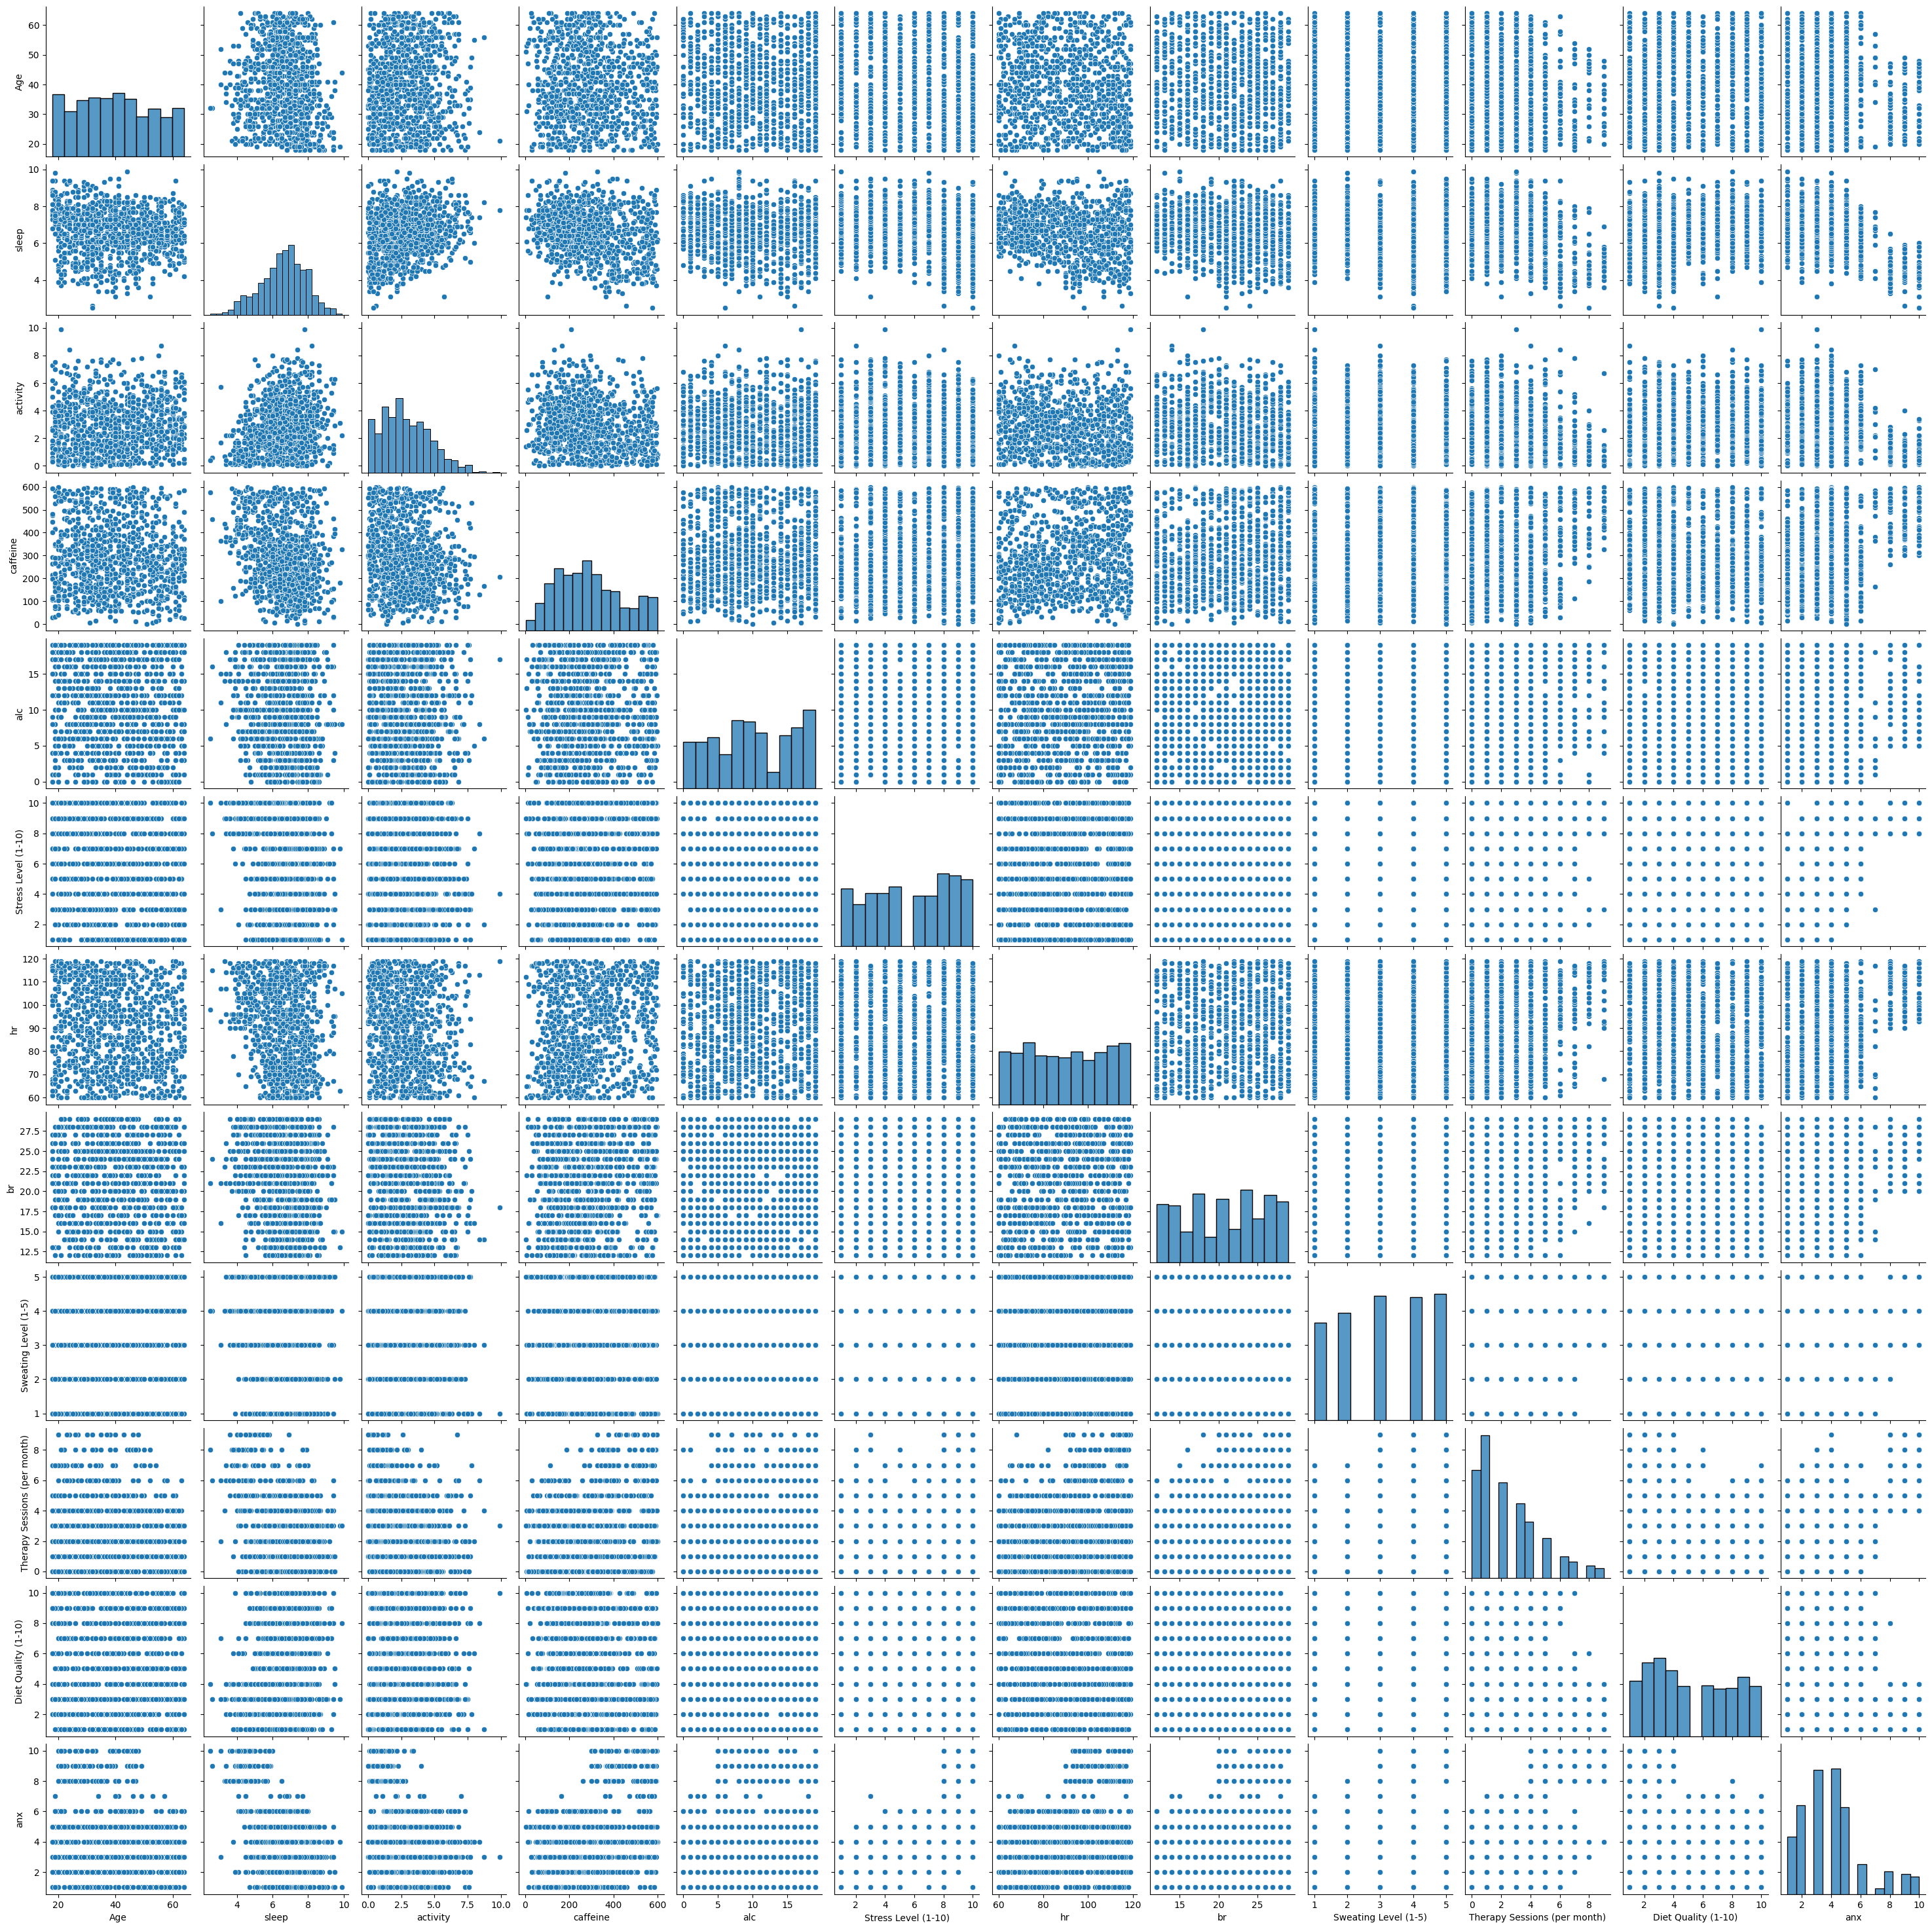

In [22]:
sns.pairplot(solarData)

In [7]:
X = solarData[["anx", "activity", "caffeine", "hr"]]
Y = solarData["sleep"].to_numpy()

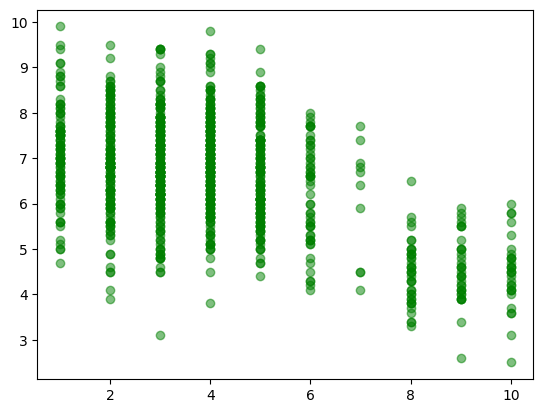

In [8]:
plt.scatter(solarData["anx"], solarData["sleep"], color='green', alpha=0.5)
plt.show()

##**PART IV: Initial BART Models**

In [9]:
with pm.Model() as model_nu:
    s = pm.HalfNormal('s', 20)
    μ_ = pmb.BART("μ_", X, Y, m=50)
    μ = pm.Deterministic("μ", μ_)
    y = pm.SkewStudentT("y", mu=μ, lam=s, a = 10, b = 30, observed=Y)
    idata_nu = pm.sample(compute_convergence_checks=False)

Output()

*Note:* I was able to corectly assume that a SkewStudentT model would work. When I looked at the posterior predictive graph, I was able to observe some right skew (a < b) although the graph generally had a "normal" trend. I was able to choose a and b valus accordingly in conjunction with my BART model.

Output()

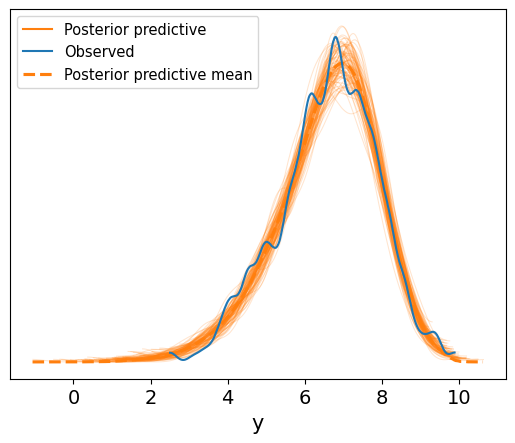

In [10]:
pm.sample_posterior_predictive(idata_nu,model_nu, extend_inferencedata=True)
ax = az.plot_ppc(idata_nu, num_pp_samples=100, colors=["C1", "C0", "C1"])

The posterior predictive check looks **really good**! The tails are matched extremely closely and the peak of the posterior predictive mean is closely aligned to the observed data. This informs me that the BART model chosen works really well for this application.

Next, I will graph the sleep prediction against anxiety level because I think that anxiety is the most important and unique feature in predicting sleep, especially because it has a lot of relevance for students.

In [11]:
posterior_mean = idata_nu.posterior["μ"]

μ_hdi = az.hdi(ary=idata_nu, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata_nu, group="posterior_predictive", var_names=["y"]
).T

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


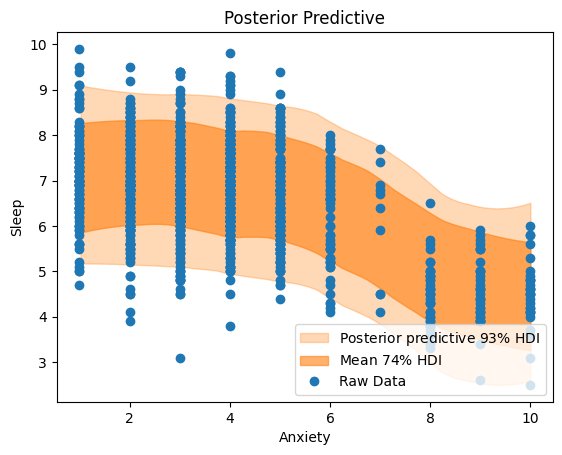

In [12]:
idx = np.argsort(X.to_numpy()[:, 0]) #grab first row
fig, ax = plt.subplots()

az.plot_hdi(
    x=X.to_numpy()[:, 0],#grab first row
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior predictive $93\%$ HDI"},
)

az.plot_hdi(
    x=X.to_numpy()[:, 0],#grab first row
    y=pps,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean $74\%$ HDI"},
)
ax.plot(solarData['anx'], solarData["sleep"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="Anxiety",
    ylabel="Sleep",
);

I think that this plot actually makes a lot of sense. The plot does NOT overfit the earlier outliers and seems to maintain a downward trend as one's anxiety increases. The plot ALSO makes a lot of sense in reality, especially as it shows that a student's amount of hours slept will decrease as their anxiety levels increase. Just looking to the student body at LASA, this general trend seems to make a lot of sense.

##**PART V: Feature Importance**

**Variable Importance Plot**

The VI Plot will help me understand which of my features is the most important.

<Axes: ylabel='R²'>

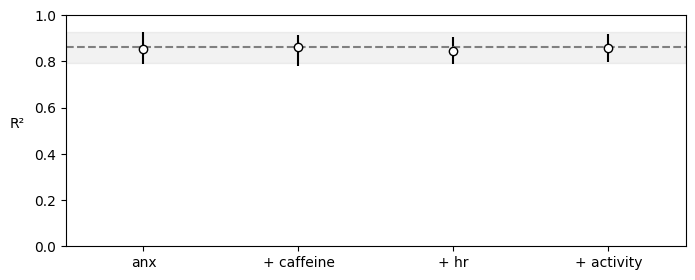

In [13]:
viPlot = pmb.compute_variable_importance(idata_nu, μ_, X)
pmb.plot_variable_importance(viPlot)

Just by looking at the VI plot, we can see that anxiety seems to be the most important variable. In the context that this dataset was taken, this actually makes a lot of sense. For high school students, anxiety is something that they all will experience. As a result, it makes sense that anxiety is going to be the most significant variable in determining sleep. Let's take a look at the PDP and ICE plots, though.

array([<Axes: xlabel='anx'>, <Axes: xlabel='activity'>,
       <Axes: xlabel='caffeine'>, <Axes: xlabel='hr'>], dtype=object)

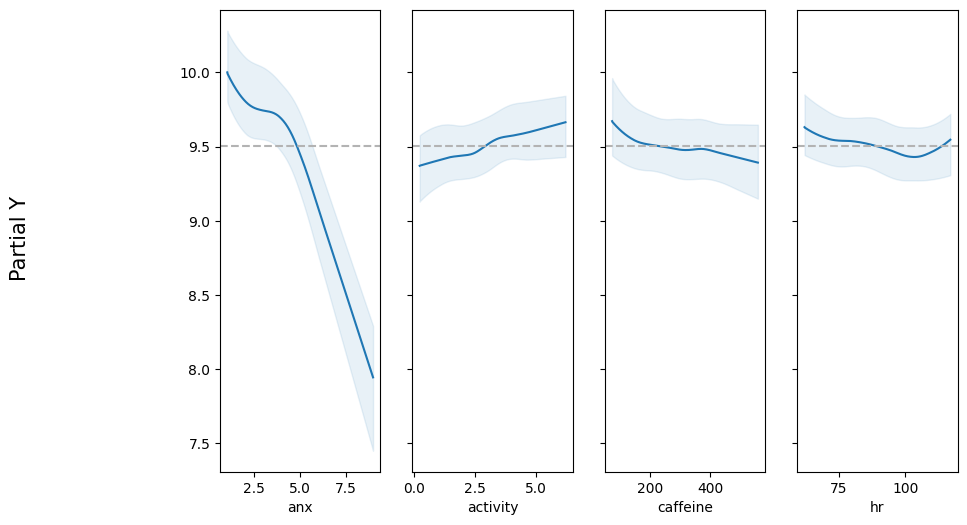

In [14]:
pmb.plot_pdp(μ_, X, Y, grid=(1, 5), figsize = (12,6))

array([<Axes: xlabel='anx'>, <Axes: xlabel='activity'>,
       <Axes: xlabel='caffeine'>, <Axes: xlabel='hr'>], dtype=object)

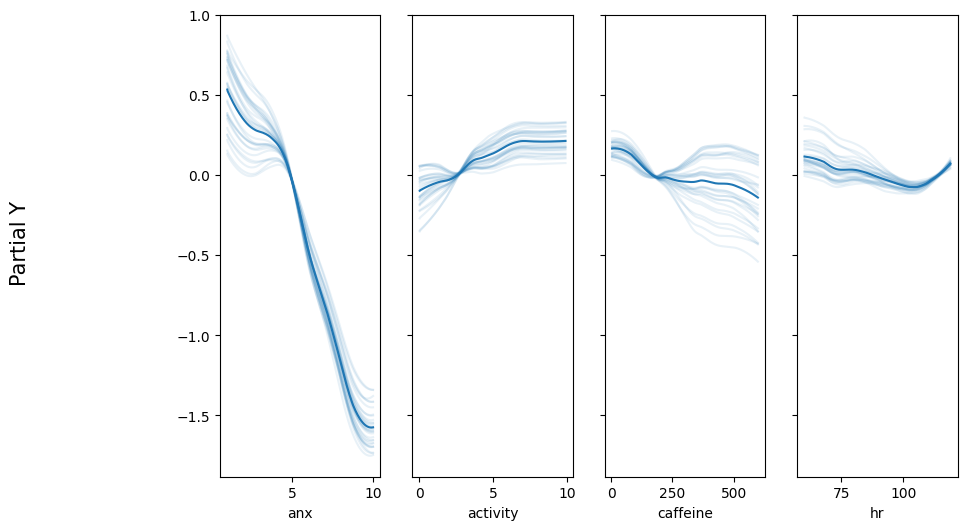

In [15]:
pmb.plot_ice(μ_, X, Y, grid=(1, 5), figsize = (12,6))

If we take a look at these new plots, they seem to be corroborating what we noticed in the VI plot by itself. The "Anxiety" feature has the largest slope, so it has the largest infuence on sleep prediction. As the amount of anxiety increase, the amount of sleep will continue to significantly decrease.

**Analysis**

The ICE plot helps to show, once again, that the "Anxiety" feature is the most important in predicting sleep. The Anxiety plot seems to indicate that there is a bit of corespondence for low values and high values of Anxiety, but not much for the middle values of Anxiety. If we put this into context, I think it actually makes sense. The midde values of Anxiety are the more average values of Anxiety that all students face, so it is likely more indpendent and not affected by other variables.

The most dependent factor seems to be the "caffeiene" variable. By looking at the ICE plot, the large number of lines show that this varaible has a lot of varying curves for all caffiene levels.

However, if we look to the other variables, we can see that the heart rate feature might actually be harming the model. If we take a look at the VI and PDP plots, we can see that the heart rate feature is harming the performance of the model. It looks to be decreasing the R^2 value, or increasing it very little compared to the other features. I want to try and create a model without heart rate to see how performance changes.

##**PART VI: Modifying Features in Model**

In [16]:
X = solarData[["anx", "activity", "caffeine"]]
Y = solarData["sleep"].to_numpy()

In [17]:
with pm.Model() as model_nu2:
    s = pm.HalfNormal('s', 20)
    μ_ = pmb.BART("μ_", X, Y, m=50)
    μ = pm.Deterministic("μ", μ_)
    y = pm.SkewStudentT("y", mu=μ, lam=s, a = 10, b = 30, observed=Y)
    idata_nu2 = pm.sample(compute_convergence_checks=False)

Output()

Output()

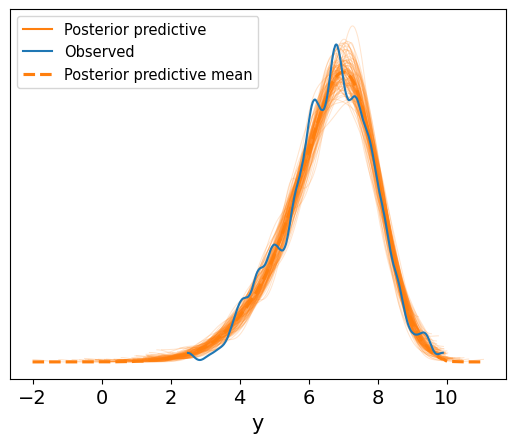

In [18]:
pm.sample_posterior_predictive(idata_nu2,model_nu2, extend_inferencedata=True)
ax = az.plot_ppc(idata_nu2, num_pp_samples=100, colors=["C1", "C0", "C1"])

<Axes: ylabel='R²'>

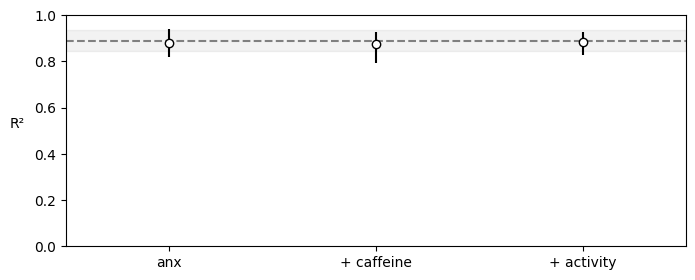

In [19]:
vi_nu2 = pmb.compute_variable_importance(idata_nu2, μ_, X)
pmb.plot_variable_importance(vi_nu2)

array([<Axes: xlabel='anx'>, <Axes: xlabel='activity'>,
       <Axes: xlabel='caffeine'>], dtype=object)

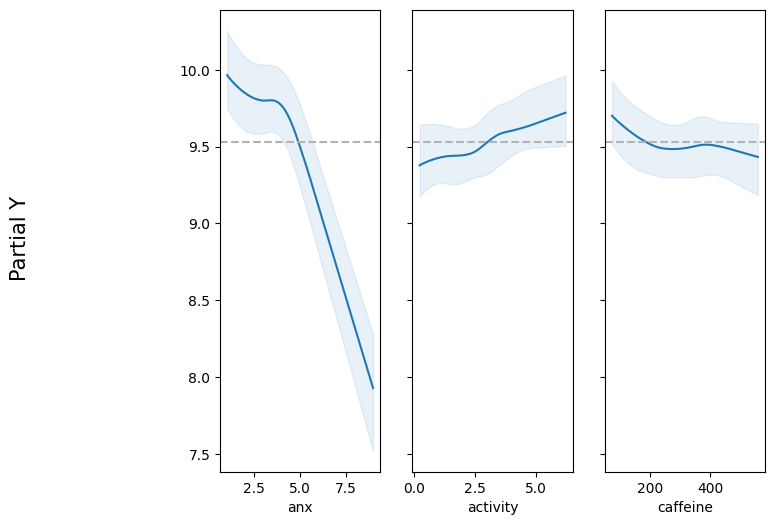

In [20]:
pmb.plot_pdp(μ_, X, Y, grid=(1, 5), figsize = (12,6))

array([<Axes: xlabel='anx'>, <Axes: xlabel='activity'>,
       <Axes: xlabel='caffeine'>], dtype=object)

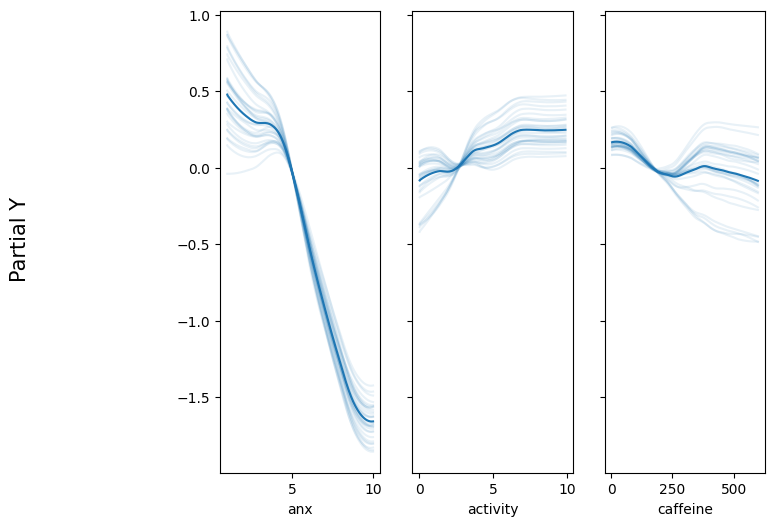

In [21]:
pmb.plot_ice(μ_, X, Y, grid=(1, 5), figsize = (12,6))

##**PART VII: Concluding Thoughts**

From the previous section, we can observe that removing heart rate did not really change model results. The PPC check pretty much produced similar results, which helps corroborate that the "Heart Rate" feature was NOT IMPORTANT at all in predicting hours of sleep. The Total R^2 value is pretty much the same, and Anxiety still seems to be the most important feature.

Compared to the ICE plot from the initial model, the activity feature ICE plot in my new model has much wider lines. This helps to show that by removing heart rate, there is now MORE INTERACTIONS between the smaller number of variables than when I included all of the features.

Here is what I am able to conlcude:
*   "Anxiety" is the most important feature for predicting sleep in school students/teenagers. Given the amount of stress they face, this makes sense in a real world context.
*   "Physical Activity" and "Caffeine Levels" have a very high interactions at large values, and "Anxiety" has high interactions at smaller values and larger values (at the extremes). Looking at my casual diagram, this makes sense because the chosen features have a lot of interactions in the casual diagram.
*   More tests need to be performed to see if additional features can improve model performance. However, since model predictions are already so accurate (as seen by the PPC), we need to ensure that we are not overfitting the model with the number of features we add.



**Adressing the variance in the "Anxiety" plot...**

**Do we really need all of our variables?**

This is a really interesting question. We have already proved, by creating another model, that the heart rate feature was not adding much to the model. We wwere able to reproduce the same accuracy by removing that feature fromt he final model. To answer this question, let's take a closer look at the ICE plot. We can see that there does not seem to be that many interactions with other variables. There is very little variance, and only at the ends of the Anxiety feature. From this, we can make two speculations.
1.   It is possible that other than "Anxiety", we do not need any of the other features. Anxiety may have such a strong dominance in the model, that any of the other features will not actually contribute much. We can already observe thsi from the PDP plots for the variables. The other features have the possibility to have a slope of 0, which would indicate that they are not adding much to the model at all. So, the little variance may indicate that there are not that many interactions between Anxiety and the over features. By that logic, "Anxiety" could stand on its own in order to predict sleep hours.
2.   However, at the same time, it is possible that doing removing the other features could remove a very important part of the models. Although their are not that many interactions, we can speculate that Anxiety has a few important intercations with these interactions. The fact that there are such little lines, and they are only near the extremes, may show that these interactions are only helpful for certain cases for "Anxiety". So, I think that we are going to need more tests to actually determine if these interactions are useful. However, the second speculation is that there are a few small interactions that are vital to model performance.



**Relevace to the real world**

In my own personal opinion, I believe that the second speculation is more likely. If we turn to modern high schools, we can observe that although a majority of students have anxiety, some students also experience other factors such as physical activity as explored in this study. Thus, it is important to recognize that the second case is much more likely, and that there are a few small interactions between the chosen variables. That's why, in the middle of the "Anxiety values", there seems to be no interactions and that is what represents the majority of the population. At the ends, the anxiety values are suppported by other features such as physical activity.